In [1]:
!pip3 install razdel pymorphy2 pyLDAvis gensim nltk

In [2]:
import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel

import pymorphy2
from nltk.corpus import stopwords
from razdel import tokenize

%matplotlib inline

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

In [3]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords


def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [4]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
churn = pd.read_csv("users_churn.csv")

In [5]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/dv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-3-c48ede91c915>:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


In [7]:
cache = {}
morph = pymorphy2.MorphAnalyzer()
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)
texts = news['title'].tolist()
common_dictionary = Dictionary(news['title'].values)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [8]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [9]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [10]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [11]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [12]:
X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [13]:
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

In [14]:
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.246548, F-Score=0.670, Precision=0.616, Recall=0.735


In [15]:
roc_auc_mean = roc_auc_score(y_test, preds)

In [16]:
mean_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Confusion matrix, without normalization
[[1643  112]
 [  66  179]]


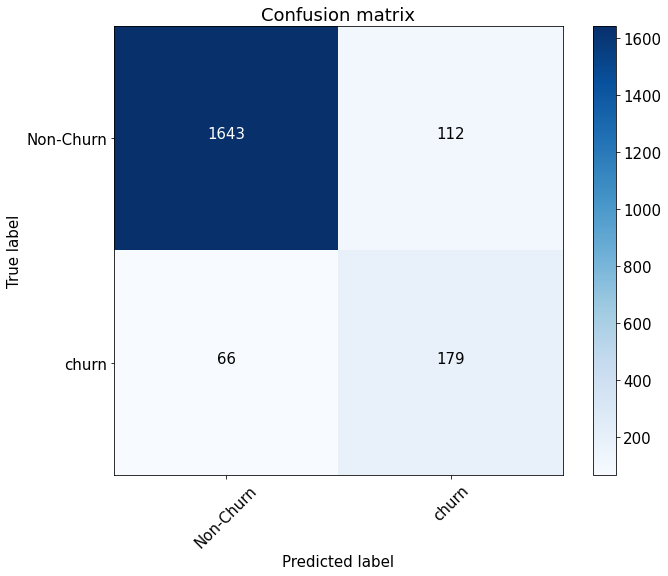

In [17]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [18]:
metrics = pd.Series({'precision': precision[ix],
                     'recall': recall[ix],
                     'f1_score': fscore[ix],
                     'roc_auc': roc_auc_mean
                    }).to_frame().T
metrics

,precision,recall,f1_score,roc_auc
0,0.616438,0.734694,0.670391,0.949602


### Задание 1

*Самостоятельно повторить tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)


#### Решение

-

### Задание 2

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

#### Решение

In [19]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding_median, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc_median = roc_auc_score(y_test, preds)

Best Threshold=0.265903, F-Score=0.790, Precision=0.755, Recall=0.829


In [20]:
median_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Confusion matrix, without normalization
[[1689   66]
 [  43  202]]


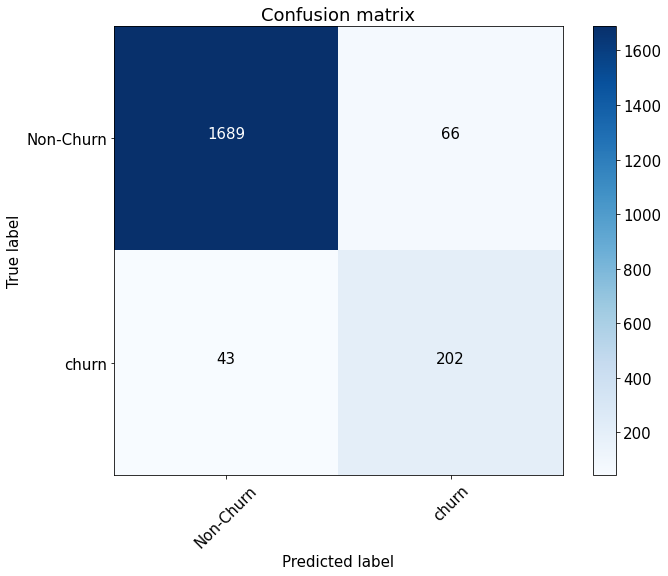

In [21]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [22]:
metrics_median = pd.Series({'precision': precision[ix],
                            'recall': recall[ix],
                            'f1_score': fscore[ix],
                            'roc_auc': roc_auc_median})
metrics = metrics.append(metrics_median, ignore_index=True)
metrics

,precision,recall,f1_score,roc_auc
0,0.616438,0.734694,0.670391,0.949602
1,0.754647,0.828571,0.789883,0.973626


### Задание 3

Повторить п.2, но используя уже не медиану, а max

#### Решение

In [23]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(get_user_embedding_max, 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, churn, 'left')
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'],
                                                    random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc_max = roc_auc_score(y_test, preds)

Best Threshold=0.357802, F-Score=0.777, Precision=0.795, Recall=0.759


In [24]:
max_rating = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]

Confusion matrix, without normalization
[[1707   48]
 [  60  185]]


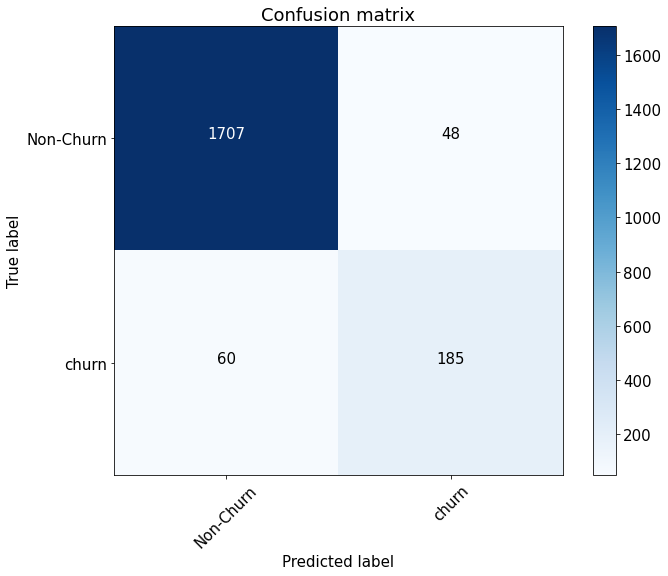

In [25]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
metrics_max = pd.Series({'precision': precision[ix],
                         'recall': recall[ix],
                         'f1_score': fscore[ix],
                         'roc_auc': roc_auc_max})
metrics = metrics.append(metrics_max, ignore_index=True)
metrics

,precision,recall,f1_score,roc_auc
0,0.616438,0.734694,0.670391,0.949602
1,0.754647,0.828571,0.789883,0.973626
2,0.794872,0.759184,0.776618,0.976561


### Задание 4

*Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)

подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал

подсказка 2: нужен именно idf, как вес.

#### Решение

-

### Задание 5

Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

#### Решение

In [27]:
summary_table = pd.DataFrame({'mean': mean_rating, 'median': median_rating, 'max': max_rating}).T
summary_table.columns=['f1_score', 'precision', 'recall', 'roc_auc_score']
summary_table

,f1_score,precision,recall,roc_auc_score
mean,0.670391,0.616438,0.734694,0.949602
median,0.789883,0.754647,0.828571,0.973626
max,0.776618,0.794872,0.759184,0.976561


### Задание 6

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Решение

user_embeddings по медиане сработало лучше, чем по максимальному значению или среднему, медиана более устойчива к выбросам.